# TP3 : Gain et impact de marché

Ethan Trentin, Alexandre Boistard

## Introduction

Ce troisième travail pratique s’inscrit dans la continuité de l’étude des 
dynamiques de marché à travers des modèles d'agents. L’objectif principal 
est d’analyser les gains obtenus par différentes catégories d’investisseurs,
ainsi que d'étudier l’impact que leurs décisions peuvent avoir sur le 
marché lui-même.

Nous nous appuierons pour cela sur le **jeu de la minorité** à nombre 
variable de spéculateurs, tel que développé dans le TP3.1. Cette version 
modifiée permettra de simuler des comportements plus réalistes et de mesurer
les effets d’interactions stratégiques entre agents.

## Objectifs

1. Étudier le gain de différentes catégories d’investisseurs.
2. Étudier l’impact de l’impact (effet retour) sur le comportement des agents.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit

1/ Fréquence de jeu et impact

In [2]:
# Dans un premier temps, crééons une fonction permettant d'initialiser les stratégies.

def initialize(Ns, P, Np):
    """La fonction initialize prend trois arguments :
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : les autres agents
    On retourne la matrice strategies, la matrice performance, ainsi que le vecteur Omega et le nombre mu."""

    # On initialise les agents avec des stratégies aléatoires entre -1 et 1
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    # On initialise les performances à 0
    performance = np.zeros(Ns)

    # On initialise omega et mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # On veut générer un nombre entre 0 et P-1 inclus
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

# Maintenant, on définit une fonction pour créer une simulation du jeu, qui va faire appel à la fonction simulation.

def simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne le vecteur A_history qui représente l'historique des actions au cours du temps, mu_history qui représente le vecteur des états au cours du temps, et la performance des agents qui est un vecteur."""

    # On passe en argument la fonction d'initialisation, en gardant en mémoire le fait qu'à la question 5 nous devrons utiliser une nouvelle initialisation des stratégies.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history = []
    mu_history = []

    for t in range(T):
        # On récupère les actions des stratégies pour l'état mu
        a_mu_t = strategies[:, mu]

        # On détermine les actions des agents en fonction de leur performance à l'aide d'une fonction de Heaviside.
        n_i = (performance >= 0) * 1
        # On calcule l'action A(t) en utilisant la somme des actions des agents et le vecteur Omega
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        # On rajoute la valeur des actions à l'instant t à l'historique
        A_history.append(A_t)

        # On met à jour la performance
        performance += -a_mu_t * A_t - epsilon

        # On met à jour la valeur de mu : on a deux méthodes disponibles (mettre à jour aléatoirement comme à l'initialisation ou mettre à jour en utilisantt les M derniers signes de A(t), mais nous allons choisir la première méthode puisque la deuxième ne nous donnait pas toujours des résultats cohérents)
        # sign = A_t > 0
        # mu = (2*mu)%2**M + sign
        mu = np.random.randint(0, P)
        mu_history.append(mu)

    return A_history, mu_history, performance

# Une fois qu'on a l'initialisation et la simulation, nous pouvons créer une fonction permettant d'afficher le résultat graphique de la simulation.

def plot_simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction plot_simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On affiche le graphique de A(t) au cours du temps."""

    # On récupère l'historique des actions grâce à la fonction simulation.
    A_history, _, _ = simulation(initialization, Ns, P, Np, M, T, epsilon)
    plt.figure(figsize=(10, 5))
    plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    plt.xlabel('Temps')
    plt.ylabel('A(t)')
    plt.title('Simulation de A(t) au cours du temps')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 100 # L'horizon temporel
Ns = 10 # Le nombre de spéculateurs
epsilon = 0.01 # La performance minimale pour continuer de participer au jeu

In [4]:
# On va afficher A_history qui est une série temporelle des actions A(t), mu_history qui représente l'historique des états and les 5 agents les plus performants.
A_history, mu_history, performance = simulation(initialize, Ns, P, Np, M, T, epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print(performance)
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 15
Final A(t): 0.1851874495163568
[-1.23584155e+02 -1.28581261e+00 -3.07783217e-03 -5.02924585e+01
 -7.62865424e+00 -4.89722839e+01 -6.61698105e+01 -2.67745441e+01
 -4.06066607e+01 -8.97007407e+01]
Top 5 performing agents: [8 7 4 1 2]


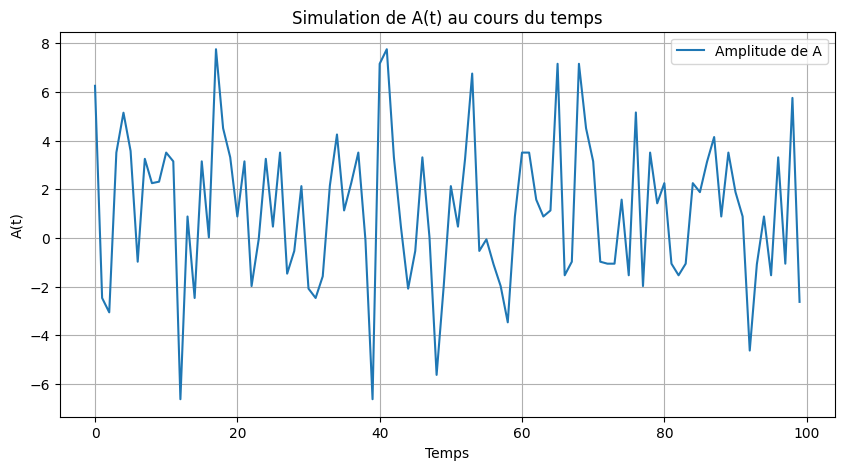

In [5]:
# Déjà, nous allons afficher la simulation pour les paramètres précédents définis.
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)